In [1]:
import pandas as pd
import numpy as np
from collections import Counter
import matplotlib.pyplot as plt
import seaborn

import planecrashinfo_light as pci

from sklearn.cluster import KMeans

from gensim import corpora, models, utils
from gensim.models import TfidfModel, LsiModel

import nltk
from nltk.corpus import stopwords

%matplotlib inline

# Raw data

In [2]:
df = pd.read_csv('data/data.csv')

# Clean(er) Data

In [3]:
df = pci.clean_database(df)
df.head()

,Time,Location,Operator,Route,AC_Type,Aboard,Fatalities,Ground,Summary,Origin,Destination,Fatalities_total,Location_Country,Accident_type
Date,,,,,,,,,,,,,,
1921-02-03,NaN,"Mendotta, Minnesota",US Aerial Mail Service,NaN,De Havilland DH-4,1 (passengers:0 crew:1),1 (passengers:0 crew:1),0.0,Shortly after takeoff from Minneapolis-World C...,NaN,NaN,1.0,USA,0
1921-02-09,NaN,"La Crosse, Wisconsin",US Aerial Mail Service,NaN,Junkers F-13,3 (passengers:0 crew:3),3 (passengers:0 crew:3),0.0,Crashed for unknown reasons. Both pilots and t...,NaN,NaN,3.0,USA,0
1921-02-15,NaN,Gibraltar,Aeropostale,NaN,Breguet 14,2 (passengers:0 crew:2),2 (passengers:0 crew:2),0.0,The mail fligh encountered poor weather condit...,NaN,NaN,2.0,Gibraltar,0
1921-02-22,NaN,"Elko, Nevada",US Aerial Mail Service,NaN,De Havilland DH-4,1 (passengers:0 crew:1),1 (passengers:0 crew:1),0.0,"Shortly after taking off, the aircraft stalled...",NaN,NaN,1.0,USA,0
1921-04-06,NaN,"Point Cook, Australia",Military - Royal Australian Air Force,NaN,Avro 504,2 (passengers:0 crew:0),2 (passengers:0 crew:0),0.0,"Shortly after taking off on a training flight,...",NaN,NaN,2.0,Australia,0


In [4]:
print('Total number of the data: {}'.format(df.shape[0]))
print('Number of the not empty summaries: {}'.format(df[df.Summary.isnull()].shape[0]))

Total number of the data: 5686
Number of the not empty summaries: 231


## Let's try to cluster summaries
We'll use Latent Dirichlet allocation (LDA). LDA is a topic model that generates topics based on word frequency from a set of documents. LDA is particularly useful for finding reasonably accurate mixtures of topics within a given document set.

In [5]:
# set data without summary as empty row
df.Summary.fillna('', inplace=True)

In [6]:
splitter = nltk.data.load('tokenizers/punkt/english.pickle')
tokenizer = nltk.tokenize.TreebankWordTokenizer()
stopset = set(stopwords.words('english'))

In [7]:
def text_to_words(text):   
    tokenized_sentences = []
    sentences = splitter.tokenize(text)
    for sentence in sentences:
        tokens = []
        # remove punctuation and stopwords
        for token in utils.tokenize(sentence, lowercase=True, deacc=True, errors="ignore"):
            if token not in stopset:                
                tokens.append(token)
                
        
        tokenized_sentences.extend(tokens)
        tokenized_sentences.extend([' '.join(bigram) for bigram in nltk.ngrams(tokens, 2)])

    return tokenized_sentences

In [8]:
texts = [text_to_words(text) for text in df.Summary.values]

In [9]:
# create dictionary
dictionary = corpora.Dictionary(texts)

In [10]:
# create documents corpus
corpus = [dictionary.doc2bow(text) for text in texts]

#### And next question is how many clusters do we have? So let's reduce number of the dimensions for visualization

In [11]:
tfidf = TfidfModel(corpus, normalize=True)
corpus_tfidf = tfidf[corpus]

We'll use module for Latent Semantic Analysis (aka Latent Semantic Indexing). It implements fast truncated SVD (Singular Value Decomposition)

In [12]:
# project to 2 dimensions for visualization
lsi_model = LsiModel(corpus_tfidf, id2word=dictionary, num_topics=2)

In [13]:
# save coordinates
coords = []

for coord in lsi_model[corpus]:
    if len(coord) > 1:
        coords.append((coord[0][1], coord[1][1]))

In [14]:
max_clusters = 10
clusters_num = range(1, max_clusters + 1)
inertias = np.zeros(max_clusters)

In [45]:
for cluster_num in clusters_num:
    kmeans = KMeans(cluster_num).fit(coords)
    # "inertia_" is sum of distances of samples to their closest cluster center
    inertias[cluster_num - 1] = kmeans.inertia_

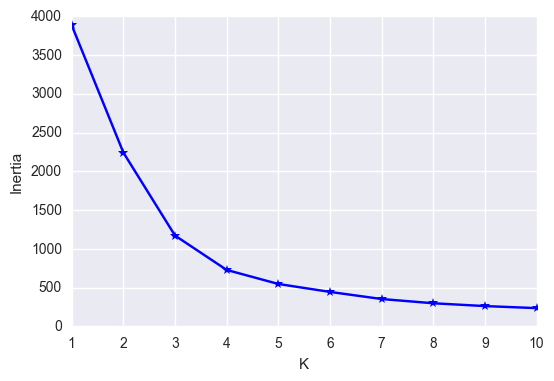

In [46]:
plt.plot(clusters_num, inertias, "b*-")

plt.ylabel("Inertia")
plt.xlabel("K")
plt.show()

In [15]:
# let's choose number of the clusters as 7
final_clusters_number = 7

kmeans = KMeans(final_clusters_number).fit(coords)

In [48]:
Counter(kmeans.labels_)

Counter({0: 1639, 1: 475, 2: 283, 3: 1782, 4: 172, 5: 91, 6: 1013})

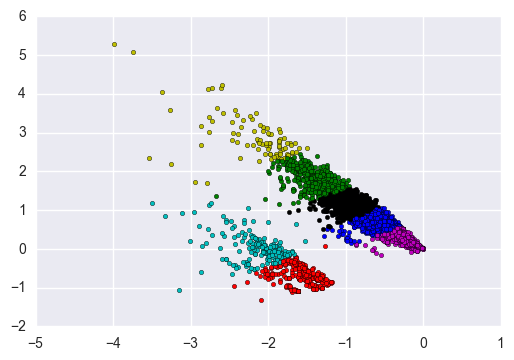

In [49]:
colors = ["b", "g", "r", "m", "c", "y", "k"]

for i in range(len(coords)):
    plt.scatter(coords[i][0], coords[i][1], c=colors[kmeans.labels_[i]], s=10)
    
plt.show()

#### Build LDA model with *num_topics = 7*

In [16]:
np.random.seed(42)

lda = models.ldamodel.LdaModel(corpus_tfidf, id2word=dictionary, num_topics=final_clusters_number, passes=20)

In [17]:
lda.show_topics(final_clusters_number, num_words=10, formatted=False)

[(0,
  [('mountains', 0.00073421738877826751),
   ('crashed mountains', 0.00069436509861507515),
   ('ambulance', 0.00054051408257431042),
   ('vfr ifr', 0.0005025991163001601),
   ('air ambulance', 0.00049514225236383356),
   ('undershot', 0.00045145956259541153),
   ('undershot runway', 0.00045129746675893703),
   ('crashed rain', 0.00034409561927385978),
   ('transport', 0.00034005479624746223),
   ('covered mountain', 0.00031760934771128143)]),
 (1,
  [('crashed takeoff', 0.0020614505549077823),
   ('takeoff', 0.0020499299562161265),
   ('taking', 0.0018232556702586337),
   ('shortly', 0.0016588909752428514),
   ('shortly taking', 0.0014907112091911453),
   ('engine', 0.0014551628399138452),
   ('crashed shortly', 0.0014429144764146978),
   ('crashed', 0.0012753074210047921),
   ('plane', 0.00103477410777143),
   ('engine failure', 0.0010006888518129062)]),
 (2,
  [('plane', 0.0028541794523827221),
   ('approach', 0.0027559918091758875),
   ('runway', 0.0026726140152651527),
   ('p

In [18]:
# approximate names of the topics

summaries_topics = [
    'crashed into', 'crashed in route', 'structural failure', 'crashed landing', 
    'crashed takeoff', 'weather conditions', 'crashed shortly'
]

# Model interpretation

In [53]:
def compute_topic_summary_matrix(model, corpus, summaries_number):
    ts_matrix = pd.DataFrame(
        data=np.zeros((final_clusters_number, summaries_number)), columns=range(summaries_number)
    )
    
    for i in range(summaries_number):
        summary_topics = model.get_document_topics(corpus[i])
        
        for topic, prob in summary_topics:
            ts_matrix[i][topic] += prob
        
    return ts_matrix

([<matplotlib.axis.XTick at 0x7fda9b3f7d30>,
 <a list of 7 Text xticklabel objects>)

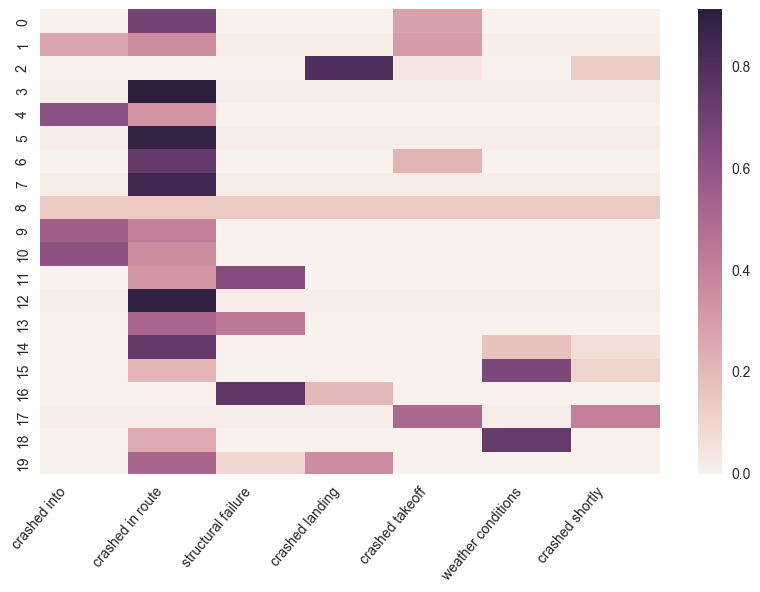

In [54]:
plt.figure(figsize=(10, 6))
seaborn.heatmap(compute_topic_summary_matrix(lda, corpus, 20).transpose())
plt.xticks(range(8), summaries_topics, rotation=50, ha='center')

In [19]:
def get_topic_summary(summary_number):
    summary_topics = lda.get_document_topics(corpus[summary_number])
    summary_topics.sort(key=lambda tup: tup[1], reverse=True)
        
    return summary_topics[0][0]

In [20]:
df['Summary_topic'] = 0

for i in range(df.shape[0]):
   df.loc[df.index[i], 'Summary_topic'] = get_topic_summary(i)

In [21]:
df.Summary_topic.value_counts()

2    3638
1     659
3     338
0     335
6     318
5     218
4     180
Name: Summary_topic, dtype: int64

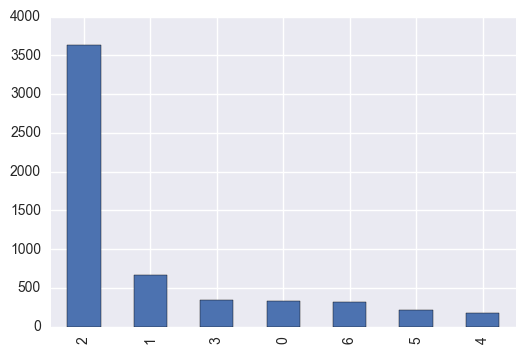

In [22]:
df.Summary_topic.value_counts().plot.bar()

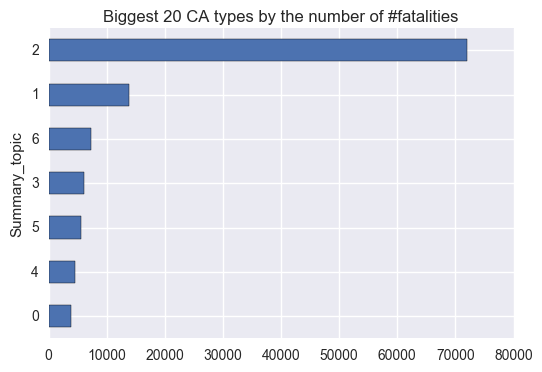

In [23]:
s = df.groupby(by=['Summary_topic']).Fatalities_total.sum().sort_values(ascending=True, na_position='first')[-20:]
s.plot.barh(title='Biggest 20 CA types by the number of #fatalities')

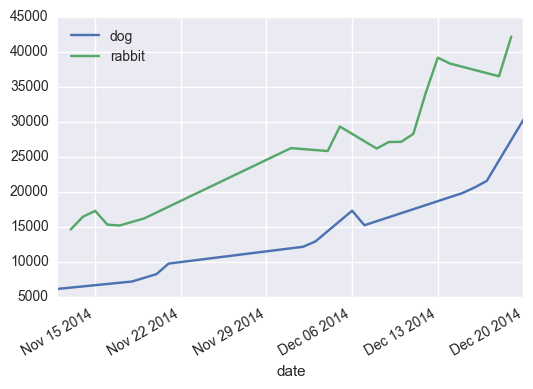

In [98]:
from pandas import Timestamp

df = pd.DataFrame({'animal': ['dog', 'rabbit', 'rabbit', 'rabbit', 'rabbit', 'rabbit', 'dog', 'rabbit', 'dog', 'dog', 'rabbit', 'dog', 'dog', 'rabbit', 'rabbit', 'dog', 'dog', 'rabbit', 'rabbit', 'rabbit', 'rabbit', 'rabbit', 'rabbit', 'rabbit', 'dog', 'dog', 'dog', 'rabbit', 'rabbit', 'dog'], 'count': [6136, 14620, 16437, 17273, 15302, 15180, 7177, 16193, 8226, 9741, 26237, 12146, 12910, 25820, 29323, 17294, 15219, 26174, 27112, 27131, 28268, 34059, 39162, 38314, 19807, 20606, 21552, 36499, 42163, 30301], 'date': [Timestamp('2014-11-12 00:00:00'), Timestamp('2014-11-13 00:00:00'), Timestamp('2014-11-14 00:00:00'), Timestamp('2014-11-15 00:00:00'), Timestamp('2014-11-16 00:00:00'), Timestamp('2014-11-17 00:00:00'), Timestamp('2014-11-18 00:00:00'), Timestamp('2014-11-19 00:00:00'), Timestamp('2014-11-20 00:00:00'), Timestamp('2014-11-21 00:00:00'), Timestamp('2014-12-01 00:00:00'), Timestamp('2014-12-02 00:00:00'), Timestamp('2014-12-03 00:00:00'), Timestamp('2014-12-04 00:00:00'), Timestamp('2014-12-05 00:00:00'), Timestamp('2014-12-06 00:00:00'), Timestamp('2014-12-07 00:00:00'), Timestamp('2014-12-08 00:00:00'), Timestamp('2014-12-09 00:00:00'), Timestamp('2014-12-10 00:00:00'), Timestamp('2014-12-11 00:00:00'), Timestamp('2014-12-12 00:00:00'), Timestamp('2014-12-13 00:00:00'), Timestamp('2014-12-14 00:00:00'), Timestamp('2014-12-15 00:00:00'), Timestamp('2014-12-16 00:00:00'), Timestamp('2014-12-17 00:00:00'), Timestamp('2014-12-18 00:00:00'), Timestamp('2014-12-19 00:00:00'), Timestamp('2014-12-20 00:00:00')]})
df = df.set_index('date')

grouped = df.groupby(['animal'])
fig, ax = plt.subplots()
for key, group in grouped:
    group['count'].plot(label=key, ax=ax)

plt.legend(loc='best')

plt.show()